Fitting 8 folds for each of 1 candidates, totalling 8 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Cross-validation scores: [0.96935933 0.95914578 0.97771588 0.95636026 0.9637883  0.96750232
 0.95728877 0.97121634 0.96471681 0.97493036 0.97214485 0.96654275]
Mean CV Accuracy: 0.9667259782382335


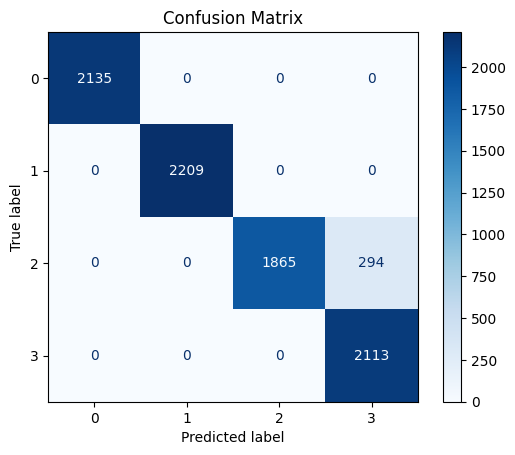

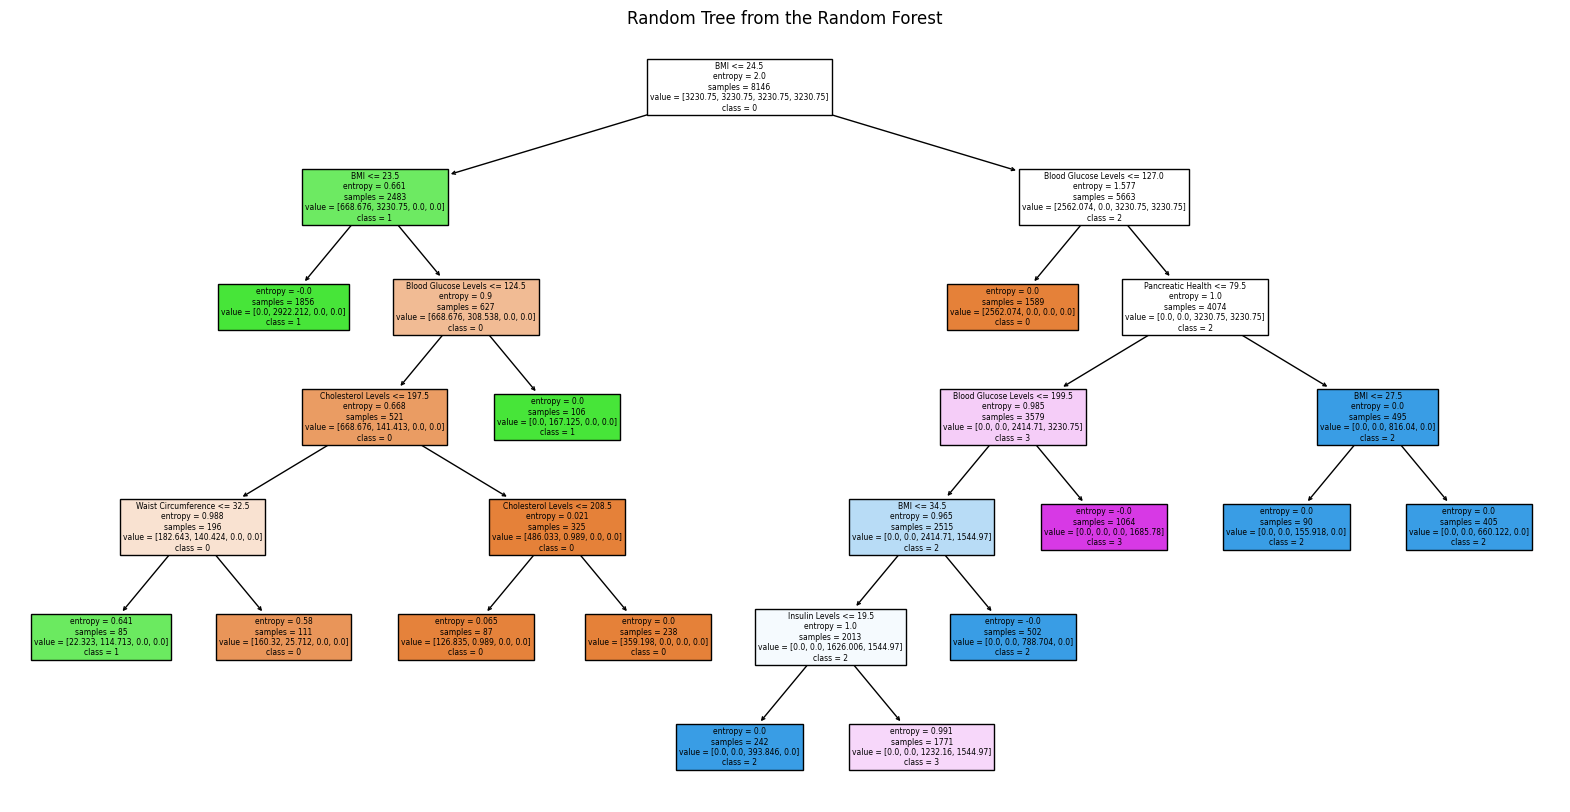

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without

In [2]:
# /**
#   *   Uses the Random Forest classifier for diabetes prediction.
#   *   Accuracy : 96.672%
#   *   Optimal Parameters :
#   *   Maximum Leaf Nodes : 25
#   *   Tree Estimators : 96
#   *   Maximum Tree Depth : 6
#   *
#   *
#   **/


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data_path = 'data.csv'
data = pd.read_csv(data_path)

X = data.drop(columns=['Target'])
y = data['Target']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

rf = RandomForestClassifier(max_leaf_nodes=25, random_state=42)

param_grid = {
    'n_estimators': [96],
    'max_depth': [6],
    'min_samples_split': [100],
    'min_samples_leaf': [80],
    'bootstrap' : [True],
    'max_features' : ['sqrt'],
    'criterion' : ['entropy'],
#   'ccp_alpha': [0.2]
    'class_weight': ['balanced_subsample']
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           #funnel plot
                           scoring='recall', cv=8, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

# Perform cost-complexity pruning
importances = best_rf.feature_importances_
important_features = np.argsort(importances)[-len(importances)//2:]
X_train_pruned = X_train #.iloc[:, important_features]
X_test_pruned = X_test #.iloc[:, important_features]

cv_scores = cross_val_score(best_rf, X_train_pruned, y_train, cv=12, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

# Fit pruned model
best_rf.fit(X_train_pruned, y_train)

y_pred = best_rf.predict(X_test_pruned)
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf.classes_)
cmd.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Plot a single random tree from the forest
random_tree = np.random.choice(best_rf.estimators_)
plt.figure(figsize=(20, 10))
plot_tree(random_tree, feature_names=X_train_pruned.columns, class_names=best_rf.classes_.astype(str), filled=True)
plt.title("Random Tree from the Random Forest")
plt.show()

tree_depths = [estimator.tree_.max_depth for estimator in best_rf.estimators_]
tree_scores = [estimator.score(X_test_pruned, y_test) for estimator in best_rf.estimators_]

# Create a DataFrame for visualization
tree_stats = pd.DataFrame({'Tree Depth': tree_depths, 'Score': tree_scores})
